# Tutorial of implementing Batch normalization
mnist image를 분류하는 Convolution Neural Network에 Batch normalization을 적용하는 간단한 example

Batch normalization paper : http://proceedings.mlr.press/v37/ioffe15.pdf

### Setup

In [1]:
import os, sys
import shutil 
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './MNIST_data', one_hot = True, reshape = True, seed = 20171104)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


### Define MnistCNN class
conv-conv-max pool-conv-conv-max pool-fc-fc

In [2]:
'''
Batch normalization의 구현을 위해서는 tf.layers module에 있는 tf.layers.batch_normalization을 활용한다. activation 하기전에
Batch normalization을 하고, 후에 activation을 한다.(전에하냐 후에하냐라는 issue가 있으나 activation 전에 하는 것이 convention이고
실험결과로 activation 전에 하는 것이 좋다는 결과도 종종 보인다.)
'''
class MnistCNN:
    def __init__(self, activation_fn = tf.nn.relu, initializer = tf.contrib.layers.variance_scaling_initializer(),
                 l2_scale = 0.02):
        
        with tf.variable_scope('input_layer'):
            self._x = tf.placeholder(dtype = tf.float32, shape = [None,784])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1,28,28,1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None,10])
            self._training = tf.placeholder(dtype = tf.bool)
            
        with tf.variable_scope('conv_layer1'):
            _conv_pre = tf.layers.conv2d(inputs = self._ximg, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_relu = activation_fn(_conv_bn)
            
        with tf.variable_scope('conv_layer2'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_relu = activation_fn(_conv_bn)
            
        with tf.variable_scope('max_pool1'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
            
        with tf.variable_scope('conv_layer3'):
            _conv_pre = tf.layers.conv2d(inputs = _pooled, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_relu = activation_fn(_conv_bn)
            
        with tf.variable_scope('conv_layer4'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_bn = tf.layers.batch_normalization(inputs = _conv_pre, momentum = .9, training = self._training)
            _conv_relu = activation_fn(_conv_bn)
            
        with tf.variable_scope('max_pool2'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
        
        with tf.variable_scope('dense_layer1'):
            _pooled_vector = tf.reshape(tensor = _pooled, shape = [-1,np.cumprod(_pooled.get_shape().as_list()[-3:])[-1]])
            _fc_pre = tf.layers.dense(inputs = _pooled_vector, units = 1024, kernel_initializer = initializer,
                                  kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _fc_bn = tf.layers.batch_normalization(inputs = _fc_pre, momentum = .9, training = self._training)
            _fc_relu = activation_fn(_fc_bn)
            
        with tf.variable_scope('output_layer'):
            self._score = tf.layers.dense(inputs = _fc_relu, units = 10, kernel_initializer = initializer,
                                          kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self._score, labels = self._y))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss +  _reg_term
        ''' 
           각각 mini_batch 마다의 mean과 variance를 계산하고, 이를 Exponential Moving Average로 저장하는 과정이 필요한 데,
           이를 수행하기위해 tf.get_collection(tf.GraphKeys.UPDATE_OPS)에서 뽑히는 ops를 저장해둔다. 이 op들은 후에
           tf.control_dependencies의 control_inputs argument에 전달된다.
           
           Note: when training, the moving_mean and moving_variance need to be updated.
           By default the update ops are placed in `tf.GraphKeys.UPDATE_OPS`, so they
           need to be added as a dependency to the `train_op`. For example:

                
               update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) <-- 본 example에서는 model 생성 class 코드에 들어가고,
                                                                           객체변수로 저장한다.
               
               with tf.control_dependencies(update_ops): <-- Solver class는 코드에 들어간다. Solver class는 model class
                   train_op = optimizer.minimize(loss)      생성된 instance를 input으로 받으므로, 거기에서 객체변수로 
                                                             저장된 update_ops를 tf.control_dependencies의 argument에 전달한다.
        '''
        # 객체변수에 model class 코드로 생성되는 graph의 UPDATE_OPS를 저장
        self._update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
        
        with tf.variable_scope('predict'):
            self._prediction = tf.argmax(input = self._score, axis = 1)
    
    def predict(self, sess, x_data, training):
        feed_predict = {self._x : x_data, self._training : training}
        return sess.run(fetches = self._prediction, feed_dict = feed_predict)

### Define Solver class

In [3]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        # Solver class는 model class로부터 생성된 instance를 input으로 받음. model class에서 저장한 객체변수를 아래와 같이 활용
        with tf.control_dependencies(self._model._update_ops):
            self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, training):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._training : training}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, training = False):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._training : training}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

### Generate CNN model and Adam solver

In [4]:
sess = tf.Session()
mnist_classifier = MnistCNN()

In [5]:
adam_solver = Solver(model = mnist_classifier)

### Training

In [6]:
# Hyper-parameters
batch_size = 100
n_epochs = 10
best_loss = np.infty
max_checks_without_progress = 15
checks_without_progress = 0
tr_loss_history = []
val_loss_history = []

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for step in range(total_batch):
        
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        val_xs, val_ys = mnist.validation.next_batch(batch_size = batch_size)
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3, training = True)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)
        
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 100 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))
    
    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)
    
     # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        checks_without_progress = 0
    else:
        checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print('Early stopping')
            break

step :   0, tr_loss : 31.353, val_loss : 31.285
step : 100, tr_loss : 3.589, val_loss : 3.813
step : 200, tr_loss : 1.709, val_loss : 1.768
step : 300, tr_loss : 0.953, val_loss : 1.186
step : 400, tr_loss : 0.780, val_loss : 0.795
step : 500, tr_loss : 0.626, val_loss : 0.742
epoch :   0, tr_loss : 2.976, val_loss : 3.082
step :   0, tr_loss : 0.648, val_loss : 0.786
step : 100, tr_loss : 0.583, val_loss : 0.452
step : 200, tr_loss : 0.502, val_loss : 0.606
step : 300, tr_loss : 0.518, val_loss : 0.511
step : 400, tr_loss : 0.351, val_loss : 0.486
step : 500, tr_loss : 0.421, val_loss : 0.838
epoch :   1, tr_loss : 0.474, val_loss : 0.632
step :   0, tr_loss : 0.396, val_loss : 0.461
step : 100, tr_loss : 0.344, val_loss : 0.486
step : 200, tr_loss : 0.316, val_loss : 0.496
step : 300, tr_loss : 0.366, val_loss : 0.355
step : 400, tr_loss : 0.364, val_loss : 0.335
step : 500, tr_loss : 0.376, val_loss : 0.603
epoch :   2, tr_loss : 0.364, val_loss : 0.448
step :   0, tr_loss : 0.592, 

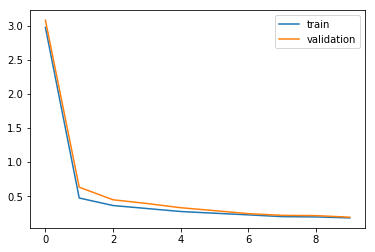

In [9]:
plt.plot(tr_loss_history, label = 'train')
plt.plot(val_loss_history, label = 'validation')
plt.legend()

In [10]:
hat = mnist_classifier.predict(sess=sess, x_data=mnist.test.images, training=False)

In [11]:
print('accuracy : {:.2%}'.format(np.mean(np.argmax(mnist.test.labels, axis = 1) == hat)))

accuracy : 95.48%
